In [24]:
# Import pandas to work with DataFrames
import pandas as pd
# Import matplotlib for plotting graphs
import matplotlib.pyplot as plt
import scipy
# Import json to change the data format
import json
# Import glob to select multiple files
import glob
# Import shutil to copy the content of a source file to a destination file
import shutil
# Import os to mimic operation system functions into python
import os
# Import datetime to interact with dates as date objects
import datetime
# Import networkx to create graphs in python
import networkx as nx
import numpy as np

In [25]:
# Select the right folder containing the data
os. chdir('/scratch/s5724090/TweetData/TwitterGEDv2')

In [26]:
# Convert the json data to DataFrame
data_list = []


file_list = glob.glob('*.txt')


for file in file_list:

    with open(file, 'r') as f:
        for line in f:
            try:
                data = json.loads(line)
                data_list.append(data)
            except json.JSONDecodeError:
                print("Error decoding JSON on line:", line)


groningen_complete = pd.json_normalize(data_list)

In [27]:
# Select the necessary columns for social network analysis
sna_columns = groningen_complete[['retweeted_status.user.id_str', 'retweeted_status.user.screen_name', 'retweeted_status.user.name', 'retweeted_status.user.description', 
                                  'user.id_str', 'user.screen_name', 'user.name','user.description' ,'created_at', 'text']]
# Rename the columns to make them unambiguous
sna_columns = sna_columns.rename(columns={'retweeted_status.user.id_str': 'retweeted_user_id', 'retweeted_status.user.screen_name': 'retweeted_user_handle', 
                            'retweeted_status.user.name': 'retweeted_user_display_name', 'retweeted_status.user.description':'retweeted_user_bio','user.id_str': 'retweeter_id', 'user.screen_name': 'retweeter_handle', 
                            'user.name': 'retweeter_display_name','user.description':'retweeter_bio'})

In [31]:
# Make datetime objects of the values in the created_at column
sna_columns['created_at'] = pd.to_datetime(sna_columns['created_at'])

# Format the values to only contain year, month and day
sna_columns['created_at'] = sna_columns['created_at'].dt.strftime('%Y-%m-%d')

# Turn them into datetime objects again
sna_columns['created_at'] = pd.to_datetime(sna_columns['created_at'])

In [32]:
# Make a function to make a new DataFrame that is filtered on the time period you need based on the first year
def filtered_df(dataframe, first_year):
    startdate = pd.to_datetime(f'{first_year}-11-16')
    enddate = pd.to_datetime(f'{first_year+1}-11-15')
    return dataframe.loc[(dataframe['created_at'] >= startdate) & (dataframe['created_at'] <= enddate)]

## Adding weight

In [33]:
# Create a function to add a weight column 
def weighted_df(dataframe):
    weight_df = dataframe[['retweeter_id', 'retweeted_user_id']]
    # All the edges receive a weight of 1
    weight_df.insert(0, 'weight', 1)
    # Through the grouping by identical edges, weight is accumulated
    weighted_dataframe = weight_df.groupby(['retweeter_id','retweeted_user_id']).sum().reset_index()
    weighted_dataframe = weighted_dataframe.dropna(ignore_index=True)
    return weighted_dataframe

In [34]:
# Create a DataFrame for each year, based on the first year.
# Create a column with weight based on occurences of identical edges
df_12_13 = weighted_df(filtered_df(sna_columns, 2012))
df_13_14 = weighted_df(filtered_df(sna_columns, 2013))
df_14_15 = weighted_df(filtered_df(sna_columns, 2014))
df_15_16 = weighted_df(filtered_df(sna_columns, 2015))
df_16_17 = weighted_df(filtered_df(sna_columns, 2016))
df_17_18 = weighted_df(filtered_df(sna_columns, 2017))
df_18_19 = weighted_df(filtered_df(sna_columns, 2018))
df_19_20 = weighted_df(filtered_df(sna_columns, 2019))
df_20_21 = weighted_df(filtered_df(sna_columns, 2020))
df_21_22 = weighted_df(filtered_df(sna_columns, 2021))

## Creating graphs

In [35]:
# Define a function that creates a graph 
def create_graph(dataframe):
    G = nx.from_pandas_edgelist(dataframe,
    # The source is the retweeter
                        source = 'retweeter_id',
    # The target is the retweeted user so that the graph is directional towards the retweeted user.
                        target = 'retweeted_user_id',
                        edge_attr = 'weight',
                             create_using=nx.DiGraph())
    return G

In [36]:
# Create a graph for all the dataframes and assign them to values
G_12_13 = create_graph(df_12_13)
G_13_14 = create_graph(df_13_14)
G_14_15 = create_graph(df_14_15)
G_15_16 = create_graph(df_15_16)
G_16_17 = create_graph(df_16_17)
G_17_18 = create_graph(df_17_18)
G_18_19 = create_graph(df_18_19)
G_19_20 = create_graph(df_19_20)
G_20_21 = create_graph(df_20_21)
G_21_22 = create_graph(df_21_22)

## Calculating the top 10 in-degree and tagging the nodes as P, M, AC or OC 
### P stands for politics, M for media, AC for action group and OC for Ordinary Citizen

In [81]:
def top_indegree(Graph):
    # Get the in-degree centrality for each node
    id_centrality = nx.in_degree_centrality(Graph)
    # Make a dataframe of the user id and centrality per user
    cent_df = pd.DataFrame.from_dict(id_centrality, orient='index', columns=['in-degree centrality']).reset_index()
    cent_df.rename(columns={'index': 'retweeted_user_id'}, inplace=True)
    # Get the display names for all the user id's
    cent_df_names = cent_df.merge(sna_columns[['retweeted_user_id', 'retweeted_user_display_name']],
                                  how='left', on='retweeted_user_id')
    unique_cent_df_names = cent_df_names.drop_duplicates(subset='retweeted_user_id')
    # Get the top 10 nodes only
    top_10 = unique_cent_df_names.sort_values('in-degree centrality', ascending=False).head(10).reset_index(drop=True)
    return top_10

In [82]:
# Assign the top 10 in-degree to a variable for all 10 graphs
top_indegree_1213 = top_indegree(G_12_13)
top_indegree_1314 = top_indegree(G_13_14)
top_indegree_1415 = top_indegree(G_14_15)
top_indegree_1516 = top_indegree(G_15_16)
top_indegree_1617 = top_indegree(G_16_17)
top_indegree_1718 = top_indegree(G_17_18)
top_indegree_1819 = top_indegree(G_18_19)
top_indegree_1920 = top_indegree(G_19_20)
top_indegree_2021 = top_indegree(G_20_21)
top_indegree_2122 = top_indegree(G_21_22)

In [83]:
# Tag all the nodes
top_indegree_1213['Tag'] = ['P','M','P','P','P','OC','OC','P','M','OC']

In [84]:
top_indegree_1314['Tag'] = ['P','P','P','M','AG','AG','OC','P','P','OC']

In [85]:
top_indegree_1415['Tag']=['OC','P','AG','M','P','AG','M','M','OC','AG']

In [86]:
top_indegree_1516['Tag']=['OC','OC','P','P','AG','P','OC','P','AG','P']

In [87]:
top_indegree_1617['Tag']=['P','OC','OC','AG','P','AG','AG','P','OC','AG']

In [88]:
top_indegree_1718['Tag']=['P','M','AG','OC','OC','OC','M','OC','OC','OC']

In [89]:
top_indegree_1819['Tag']=['P','OC','OC','AG','P','OC','AG','AG','OC','P']

In [90]:
top_indegree_1920['Tag']=['P','OC','OC','P','OC','OC','AG','OC','OC','AG']

In [91]:
top_indegree_2021['Tag']=['P','OC','OC','OC','OC','AG','M','P','M','OC']

In [92]:
top_indegree_2122['Tag']=['P','M','OC','M','P','M','OC','OC','OC','OC']

In [93]:
# Create a list with all the tagged DataFrames
in_degree_years = [top_indegree_1213, top_indegree_1314, top_indegree_1415, top_indegree_1516, top_indegree_1617,
                   top_indegree_1718, top_indegree_1819, top_indegree_1920, top_indegree_2021, top_indegree_2122]
# Loop over the DataFrames to count the amount of P, M, AG and OC nodes there were in each year
# Then append those numbers to the right tag, so they are in the right format for the stacked bar plot
p = []
m = []
ag = []
oc = []
for year in in_degree_years:
    p.append((year['Tag']=='P').sum())
    m.append((year['Tag']=='M').sum())
    ag.append((year['Tag']=='AG').sum())
    oc.append((year['Tag']=='OC').sum())

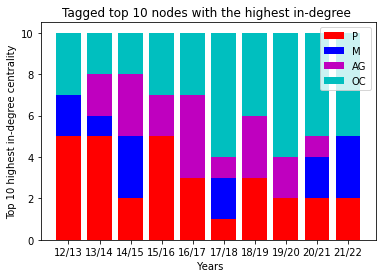

In [50]:
# Create the stacked bar plot
# The years are the x-axis
x = ['12/13', '13/14', '14/15', '15/16', '16/17', '17/18', '18/19', '19/20', '20/21', '21/22']

# Create the bars
plt.bar(x, p, color='r', label='P');
# Make sure the segments do not overlap by using the bottom parameter
plt.bar(x, m, bottom=p, color='b', label='M');
plt.bar(x, ag, bottom=[i + j for i, j in zip(p, m)], color='m', label='AG');
plt.bar(x, oc, bottom=[i + j + k for i, j, k in zip(p, m, ag)], color='c', label='OC');

# Add labels and title
plt.xlabel(' Years')
plt.ylabel('Top 10 highest in-degree centrality')
plt.title('Tagged top 10 nodes with the highest in-degree ')
plt.legend();

## Tagging the top 10 nodes with the highest out-degree centrality

In [51]:
# Define a function to calculate the out-degree centrality
def top_outdegree(Graph):
    # Get the in-degree centrality for each node
    id_centrality = nx.out_degree_centrality(Graph)
    # Make a dataframe of the user id and centrality per user
    cent_df = pd.DataFrame.from_dict(id_centrality, orient='index', columns=['out-degree centrality']).reset_index()
    cent_df.rename(columns={'index': 'retweeter_id'}, inplace=True)
    # Get the display names for all the user id's
    cent_df_names = cent_df.merge(sna_columns[['retweeter_id', 'retweeter_display_name']], how='left', on='retweeter_id')
    unique_cent_df_names = cent_df_names.drop_duplicates(subset='retweeter_id')
    top_10 = unique_cent_df_names.sort_values('out-degree centrality', ascending=False).head(10).reset_index(drop=True)
    return top_10

In [52]:
# Assign the top 10 in-degree to a variable for all 10 graphs
top_outdegree_1213 = top_outdegree(G_12_13)
top_outdegree_1314 = top_outdegree(G_13_14)
top_outdegree_1415 = top_outdegree(G_14_15)
top_outdegree_1516 = top_outdegree(G_15_16)
top_outdegree_1617 = top_outdegree(G_16_17)
top_outdegree_1718 = top_outdegree(G_17_18)
top_outdegree_1819 = top_outdegree(G_18_19)
top_outdegree_1920 = top_outdegree(G_19_20)
top_outdegree_2021 = top_outdegree(G_20_21)
top_outdegree_2122 = top_outdegree(G_21_22)

In [53]:
top_outdegree_1213['Tag']=['OC','OC','OC','AG','OC','OC','AG','AG','OC','OC']

In [54]:
top_outdegree_1314['Tag']=['AG','OC','OC','OC','OC','AG','P','OC','AG','P']

In [55]:
top_outdegree_1415['Tag']=['OC','OC','OC','OC','AG','OC','AG','OC','OC','OC']

In [56]:
top_outdegree_1516['Tag']=['OC','AG','OC','OC','OC','AG','OC','OC','OC','OC']

In [57]:
top_outdegree_1617['Tag']=['OC','OC','OC','AG','OC','AG','OC','OC','OC','OC']

In [58]:
top_outdegree_1718['Tag']=['OC','OC','OC','OC','OC','AG','OC','OC','OC','OC']

In [59]:
top_outdegree_1819['Tag']=['OC','OC','OC','OC','OC','OC','OC','OC','OC','AG']

In [60]:
top_outdegree_1920['Tag']=['OC','OC','OC','OC','AG','AG','AG','OC','OC','OC']

In [61]:
top_outdegree_2021['Tag']=['OC','OC','OC','OC','OC','OC','OC','OC','OC','OC']

In [62]:
top_outdegree_2122['Tag']=['OC','OC','OC','OC','OC','OC','OC','OC','OC','OC']

In [63]:
# Create a list with all the tagged DataFrames so they can be looped over  
in_degree_years = [top_outdegree_1213, top_outdegree_1314, top_outdegree_1415, top_outdegree_1516,
                   top_outdegree_1617, top_outdegree_1718, top_outdegree_1819, top_outdegree_1920,
                   top_outdegree_2021, top_outdegree_2122]
# Loop over the DataFrames to count the amount of P, M, AG and OC nodes there were in each year
# Then append those numbers to the right tag, so they are in the right format for the stacked bar plot
p = []
m = []
ag = []
oc = []
for year in in_degree_years:
    p.append((year['Tag']=='P').sum())
    m.append((year['Tag']=='M').sum())
    ag.append((year['Tag']=='AG').sum())
    oc.append((year['Tag']=='OC').sum())

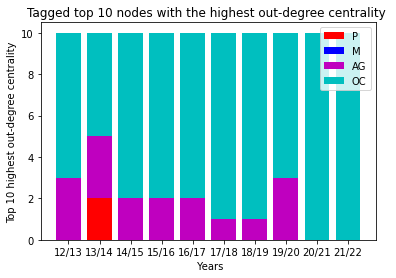

In [64]:
# Create the stacked bar plot
# The years are the x-axis
x = ['12/13', '13/14', '14/15', '15/16', '16/17', '17/18', '18/19', '19/20', '20/21', '21/22']

# Create the bars
plt.bar(x, p, color='r', label='P');

# Make sure the segments do not overlap by using the bottom parameter
plt.bar(x, m, bottom=p, color='b', label='M');
plt.bar(x, ag, bottom=[i + j for i, j in zip(p, m)], color='m', label='AG');
plt.bar(x, oc, bottom=[i + j + k for i, j, k in zip(p, m, ag)], color='c', label='OC');

# Add labels and title
plt.xlabel(' Years')
plt.ylabel('Top 10 highest out-degree centrality')
plt.title('Tagged top 10 nodes with the highest out-degree centrality ')
plt.legend();

## Tagging the top 10 nodes with the highest betweenness centrality

In [65]:
# Make a DataFrame with all users and their tweets to identify the users that have the highest centrality metrics
# Combine the user ids and display names into one dataframe
all_users = pd.concat([
    sna_columns[['retweeted_user_id', 'retweeted_user_handle','retweeted_user_display_name', 'retweeted_user_bio', 'text']].rename(columns={'retweeted_user_id': 'user_id', 'retweeted_user_handle':'user_handle','retweeted_user_display_name': 'display_name','retweeted_user_bio':'user_bio'}),
    sna_columns[['retweeter_id','retweeter_handle', 'retweeter_display_name', 'retweeter_bio','text']].rename(columns={'retweeter_id': 'user_id', 'retweeter_handle':'user_handle','retweeter_display_name': 'display_name', 'retweeter_bio':'user_bio'})])
# Get rid of the duplicate tweets and drop null values
all_users = all_users.drop_duplicates().dropna()

In [66]:
# Create a function to get the highest betweenness centrality
def top_betweenness(Graph):
    get_betweenness = nx.betweenness_centrality(Graph)
    betweenness_df = pd.DataFrame.from_dict(get_betweenness, orient='index', columns=['Betweenness centrality']).reset_index()
    betweenness_df.rename(columns={'index': 'user_id'}, inplace=True)
    betweenness_names = betweenness_df.merge(all_users[['user_id', 'display_name']], how='left', on='user_id')
    unique_betweenness_names = betweenness_names.drop_duplicates(subset='user_id')
    # Return the top 10
    top_10 = unique_betweenness_names.sort_values('Betweenness centrality', ascending=False).head(10).reset_index(drop=True)
    return top_10

In [67]:
# Calculate the nodes with the top 10 highest betweenness centrality
top_betweeenness_1213 = top_betweenness(G_12_13)
top_betweeenness_1314 = top_betweenness(G_13_14)
top_betweeenness_1415 = top_betweenness(G_14_15)
top_betweeenness_1516 = top_betweenness(G_15_16)
top_betweeenness_1617 = top_betweenness(G_16_17)
top_betweeenness_1718 = top_betweenness(G_17_18)
top_betweeenness_1819 = top_betweenness(G_18_19)
top_betweeenness_1920 = top_betweenness(G_19_20)
top_betweeenness_2021 = top_betweenness(G_20_21)
top_betweeenness_2122 = top_betweenness(G_21_22)

In [68]:
top_betweeenness_1213['Tag']=['AG','OC','AG','AG','OC','OC','P','P','M','P']

In [69]:
top_betweeenness_1314['Tag']=['AG','OC','AG','AG','P','OC','OC','OC','P','OC']

In [70]:
top_betweeenness_1415['Tag']=['OC','OC','AG','P','OC','OC','AG','OC','P','M']

In [71]:
top_betweeenness_1516['Tag']=['OC','OC','OC','AG','OC','OC','P','P','AG','AG']

In [72]:
top_betweeenness_1617['Tag']=['OC','OC','P','AG','AG','AG','OC','P','AG','OC']

In [73]:
top_betweeenness_1718['Tag']=['OC','P','OC','OC','OC','OC','AG','OC','AG','OC']

In [74]:
top_betweeenness_1819['Tag']=['OC','OC','OC','AG','OC','AG','P','AG','OC','AG']

In [75]:
top_betweeenness_1920['Tag']=['OC','OC','OC','OC','OC','OC','AG','AG','OC','OC']

In [76]:
top_betweeenness_2021['Tag']=['OC','OC','AG','P','OC','P','OC','M','OC','OC']

In [77]:
top_betweeenness_2122['Tag']=['OC','OC','AG','OC','OC','OC','AG','OC','OC','OC']

In [80]:
# Create a list with all the tagged DataFrames so they can be looped over  
in_degree_years = [top_betweeenness_1213, top_betweeenness_1314, top_betweeenness_1415, 
                   top_betweeenness_1516, top_betweeenness_1617, top_betweeenness_1718, 
                   top_betweeenness_1819, top_betweeenness_1920, top_betweeenness_2021, top_betweeenness_2122]
# Loop over the DataFrames to count the amount of P, M, AG and OC nodes there were in each year
# Then append those numbers to the right tag, so they are in the right format for the stacked bar plot
p = []
m = []
ag = []
oc = []
for year in in_degree_years:
    p.append((year['Tag']=='P').sum())
    m.append((year['Tag']=='M').sum())
    ag.append((year['Tag']=='AG').sum())
    oc.append((year['Tag']=='OC').sum())

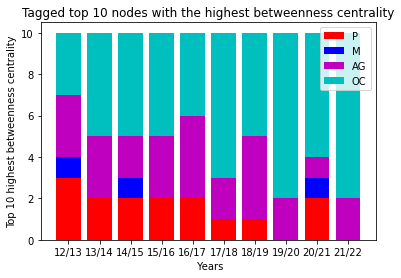

In [79]:
# Create the stacked bar plot
# The years are the x-axis
x = ['12/13', '13/14', '14/15', '15/16', '16/17', '17/18', '18/19', '19/20', '20/21', '21/22']

# Create the bars
plt.bar(x, p, color='r', label='P');

# Make sure the segments do not overlap by using the bottom parameter
plt.bar(x, m, bottom=p, color='b', label='M');
plt.bar(x, ag, bottom=[i + j for i, j in zip(p, m)], color='m', label='AG');
plt.bar(x, oc, bottom=[i + j + k for i, j, k in zip(p, m, ag)], color='c', label='OC');

# Add labels and title
plt.xlabel(' Years')
plt.ylabel('Top 10 highest betweenness centrality')
plt.title('Tagged top 10 nodes with the highest betweenness centrality')
plt.legend();